In [1]:
import datetime 
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import scipy
import seaborn as sns
%matplotlib inline

sns.set_style("white")

------------ 

# Data preparation

In [2]:
# read the data
cars = pd.read_csv("autos.csv", encoding="Latin1", parse_dates = ['dateCrawled','dateCreated','lastSeen'])

In [3]:
# clean the data:
# only these values make sense for car age:
cars = cars[(cars.yearOfRegistration < 2017) & (cars.yearOfRegistration > 1900)]
# we don't want to have non-sensible prices:
cars = cars[(cars.price < 500000) & (cars.price > 500)]
# only interested in working cars for now:
cars = cars[cars.notRepairedDamage != "ja"]

In [4]:
cars = cars.assign(mileage_cat=[("low", "medium", "med-high", "high")[min(3, int(math.floor(x/50000)))] for x in cars.kilometer])

In [5]:
# age is a better feature than year of registration
# here we use the number of days since registration
cars = cars.assign(age=[datetime.timedelta(seconds=(x.dateCreated.timestamp() - 
                        (datetime.datetime.strptime(
                            str(x.yearOfRegistration) + str(x.monthOfRegistration), "%Y%M")).timestamp())).days
                        for i, x in cars.iterrows()])

In [6]:
# only use cars not registered in the future
cars = cars[cars.age > 0]

In [7]:
# save the modified csv
cars.to_csv("autos.mod.csv")

In [11]:
# to start with cleaned & modified data:
cars = pd.read_csv("autos.mod.csv")

In [4]:
cars.offerType.value_counts()

Angebot    292692
Gesuch          3
Name: offerType, dtype: int64

In [10]:
#cars.plot(x="yearOfRegistration", y="price", kind="scatter", ylim=(0, 1000000))
plt.figure()
sns.lmplot('age', 'price', data=cars, fit_reg=False, hue="brand")
plt.xlim(0, 50000)

(0, 50000)

In [11]:
# most common models
cars.model.value_counts()[:20]

golf           23435
andere         20893
3er            17214
polo            9131
a4              8674
passat          8482
corsa           8364
astra           8094
c_klasse        7784
5er             7485
e_klasse        6562
a3              5604
a6              5120
transporter     4720
focus           4708
fiesta          4011
2_reihe         4004
fortwo          3847
1er             3511
a_klasse        3483
Name: model, dtype: int64

In [46]:
# get general depreciation
from sklearn import linear_model
clf = linear_model.LinearRegression()
clf.fit(cars.loc[:, ("kilometer", "yearOfRegistration")], y=cars.price)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [47]:
clf.coef_

array([ -8.10373297e-02,   2.49144470e+02])

In [ ]:
# compare depreciation per model

In [13]:
cars.yearOfRegistration.hist()

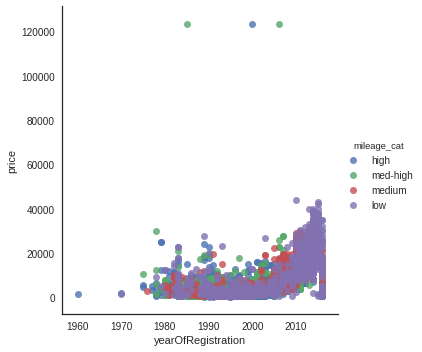

In [109]:

sns.lmplot('yearOfRegistration', 'price', data=cars[cars.model=="golf"], fit_reg=False, hue="mileage_cat")

In [15]:

sns.lmplot('yearOfRegistration', 'price', data=cars[cars.model=="1er"], fit_reg=False, hue="mileage_cat")

In [16]:
sns.lmplot('yearOfRegistration', 'price', data=cars[cars.model=="3er"], fit_reg=False, hue="mileage_cat")

In [17]:
sns.countplot(x="yearOfRegistration", hue="mileage_cat", data=cars[cars.model=="3er"])

In [69]:
# write function for fit parameters for one model
# run function for all models > 100 entries
# test accuracy for each
# see how good my accuracy is, maybe also depending on input data

In [4]:
def randomize(x, y, length):
    random_indices = list(range(length))
    random.shuffle(random_indices)
    x = x[random_indices]
    y = y[random_indices]
    return x, y


def calc_grad(x, y, theta, lamb=0):
    #import pdb; pdb.set_trace()
    cor_theta = theta.copy()
    m = x.shape[0]  # number of training examples
    h = np.dot(x, theta)  # predicted y values
    cor_theta[0] = 0  # theta_0 does not count for regularization
    grad = np.dot(x.T, (np.subtract(h, y))).T/m + (lamb/m) * cor_theta
    if len(grad.shape) > 1:
        grad = grad[0]
    return grad


def cost(x, y, theta, lamb=0):
    #import pdb; pdb.set_trace()
    cor_theta = theta.copy()
    m = x.shape[0]  # number of training examples
    h = np.dot(x, theta)  # predicted y values
    cor_theta[0] = 0  # theta_0 does not count for regularization
    j = np.sum((np.subtract(h, y) ** 2))/(2*m) + (lamb/(2*m)) * sum(cor_theta**2)
    return j
    

def normal_equation(train_x, train_y, lamb):
    # normal equation
    reg = np.zeros((train_x.shape[1], train_x.shape[1]))
    np.fill_diagonal(reg, 1)
    reg[0, 0] = 0
    reg = lamb * reg
    theta = np.dot(np.dot(np.linalg.pinv(np.dot(train_x.T, train_x) + reg),
                          train_x.T), train_y)
    return theta

                  
def gradient_descent(x, y, lamb):
    initial_theta = np.ones(x.shape[1]) * 0.1
    cf = lambda t: cost(x, y, t, lamb)
    cf_grad = lambda t: calc_grad(x, y, t, lamb)
    theta = scipy.optimize.fmin_cg(cf, initial_theta, cf_grad)
    return theta
                  

def train_parameters(train_x, train_y, cv_x, cv_y):
    # choose lambda
    lambdas = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
    train_errors, cv_errors = [], []
    # train = normal_equation if train_x.shape[1] < 1000 else gradient_descent
    train = gradient_descent
    for lamb in lambdas:
        theta = train(train_x, train_y, lamb)
        train_error = cost(train_x, train_y, theta)
        train_errors.append(train_error)
        cv_error = cost(cv_x, cv_y, theta)
        cv_errors.append(cv_error)
    print(train_errors)
    print(cv_errors)


def learning_curve(train_x, train_y, cv_x, cv_y, lamb=0):
    """Plot learning curve -> change in training & cv error"""
    train_errors, cv_errors = [], []
    #train = normal_equation if train_x.shape[1] < 1000 else gradient_descent
    train = gradient_descent
    for n in range(1 if len(train_x) < 20 else len(train_x)// 20,
                   len(train_x),
                   len(train_x)//20 if len(train_x) > 20 else 1):
        theta = train(train_x[:n], train_y[:n], lamb)
        train_error = cost(train_x[:n], train_y[:n], theta)
        train_errors.append(train_error)
        cv_error = cost(cv_x, cv_y, theta)
        cv_errors.append(cv_error)
    plt.figure()
    plt.plot(train_errors)
    plt.plot(cv_errors)
    plt.legend(("train", "cv"))


def scale(x):
    #import pdb; pdb.set_trace()
    mu = x.mean(axis=0)
    x = x - mu
    sigma = x.std(axis=0)
    x = x/sigma
    return x, mu, sigma

def add_polynoms(x):
    #import pdb; pdb.set_trace()
    old_x = x.copy()
    for i in [0.5, 2, 3]:
        x = np.append(x, old_x**i, axis=1)
    return x


def fit_params(x, y):
    """Fit a linear regression to predict response vector y from feature matrix x.
    """
    x, y = np.array(x), np.array(y)
    # add polymonial features
    # feature scaling
    x, mu, s = scale(x)
    #x = add_polynoms(x)
    # first: randomize order
    len_x, len_y = x.shape[0], y.shape[0]
    x = np.insert(x, 0, 1, axis=1)
    if len_x != len_y:
        raise ValueError("Error: features x and response y have different lengths")
    x, y = randomize(x, y, len_x)
    # second: separate into training, cv, and test set
    div1, div2 = math.floor(len_x * 0.6), math.floor(len_x * 0.8)
    train_x, train_y = x[:div1], y[:div1]
    cv_x, cv_y = x[div1:div2], y[div1:div2]
    test_x, test_y = x[div2:], y[div2:]
    learning_curve(train_x, train_y, cv_x, cv_y)
    theta = train_parameters(train_x, train_y, cv_x, cv_y)


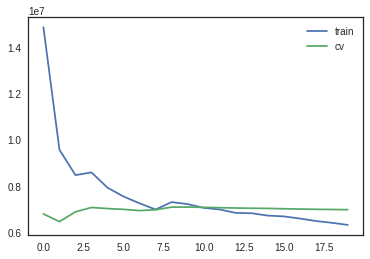

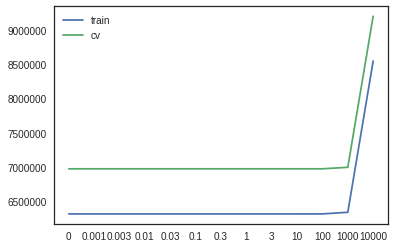

In [48]:
# try to fit model
import main
import importlib
importlib.reload(main)
main.fit_params(cars[cars.model=="golf"].loc[:, ("powerPS", "kilometer", "age")], cars.price[cars.model=="golf"])

In [13]:
fit_params(cars[cars.model=="3er"].loc[:, ("powerPS", "kilometer", "age")], cars.price[cars.model=="3er"])

[9098398.3775719255, 9098398.3988635354, 9098398.5687961429, 9098400.4868305102, 9098416.9718291946, 9098590.8619194534, 9099832.379682716, 9107643.3115832768, 9128716.580684524, 9171559.1681712363]
[33883438.350964755, 33883513.407945976, 33883663.297886319, 33884185.572185993, 33885658.010674044, 33890591.546619922, 33903040.524464712, 33933652.81191057, 33975171.015049942, 34027842.543601006]


In [31]:
plt.xticks?

In [5]:
# test functions using old stuff
df = pd.read_csv('/home/john/Dokumente/ml-course/ex1/ex1data2.txt', header=None)
x = df.loc[:, (0, 1)]
y = df.loc[:, (2)]
x, mu, s = scale(x)
x = x.as_matrix()
x = np.insert(x, 0, 1, axis=1)

# test unregularized gradient descent:
assert np.sum(gradient_descent(x, y, 0) - np.array([ 340412.65957447,  110631.0502789 ,   -6649.47427087])) < 0.00001
assert np.sum(normal_equation(x, y, 0) - np.array([ 340412.65957447,  110631.0502789 ,   -6649.47427087])) < 0.00001

ValueError: shapes (47,3) and (2,) not aligned: 3 (dim 1) != 2 (dim 0)

In [8]:
# test functions using old stuff
import scipy.io as sio
d = sio.loadmat('/home/john/Dokumente/ml-course/ex5/ex5data1.mat')
X = np.insert(d["X"], 0, 1, axis=1)
Xval = np.insert(d["Xval"], 0, 1, axis=1)
Xtest = np.insert(d["Xtest"], 0, 1, axis=1)
#cost(X, d["y"].ravel(), np.array([1, 1]), 1)
#calc_grad(X, d["y"].ravel(), np.array([1, 1]))
#learning_curve(X, d["y"].ravel(), Xval, d["yval"].ravel())
x = np.vstack([X, Xval, Xtest])[:,1]
y = np.vstack([d["y"], d["yval"], d["ytest"]]).ravel()

# test cost function
print(cost(np.vstack([X, Xval, Xtest]), y, np.array([1, 1])))

#fit_params(pd.DataFrame(x), pd.DataFrame(y))

334.723100006


In [ ]:
d = sio.loadmat('/home/john/Dokumente/ml-course/ex1/ex1data1.mat')